# Variational Autoencoders applied to Pokemon sprites

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Load the data

In [415]:
DATA_PATH = './sprites/sprites/pokemon/'

In [647]:
sprites = []
maxSize = 0
minSize = 1000000
for file in os.listdir(DATA_PATH):
    if file.endswith('.png'):
        sprite = cv2.imread(DATA_PATH + file, cv2.IMREAD_GRAYSCALE)
        if sprite is not None:
            sprites.append(sprite)
            if sprite.shape[0] > maxSize:
                maxSize = sprite.shape[0]
            if sprite.shape[0] < minSize:
                minSize = sprite.shape[0]

for i in range(len(sprites)):
    sprites[i] = cv2.resize(sprites[i], (minSize // 2, minSize // 2), interpolation=cv2.INTER_AREA)

sprites = np.array(sprites)
print(sprites.shape)

(1505, 48, 48)


In [648]:
#select only the sprites with the first pixel black
sprites = sprites[sprites[:, 0, 0] == 0]
sprites.shape

(1158, 48, 48)

In [649]:
_, height, width = sprites.shape
channels = 1
sprites = sprites.reshape(-1, height, width, channels)

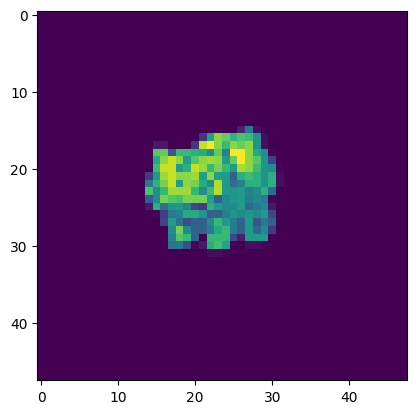

In [650]:
plt.imshow(sprites[1])
plt.show()

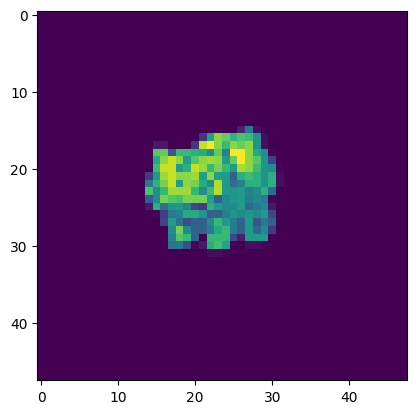

In [651]:
normalizedSprites = sprites / 255.0
plt.imshow(normalizedSprites[1])
plt.show()

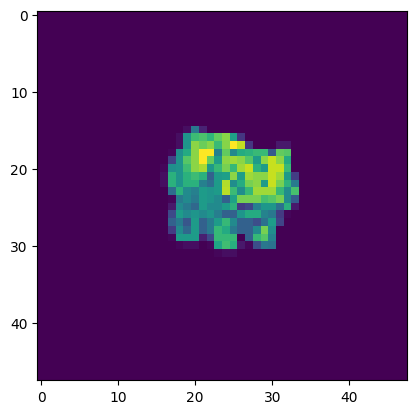

(2316, 48, 48, 1)

In [656]:
#add horizontal flip
flippedSprites = np.flip(normalizedSprites, axis=2)
plt.imshow(flippedSprites[1])
plt.show()
sprites = np.concatenate((normalizedSprites, flippedSprites), axis=0)
sprites.shape

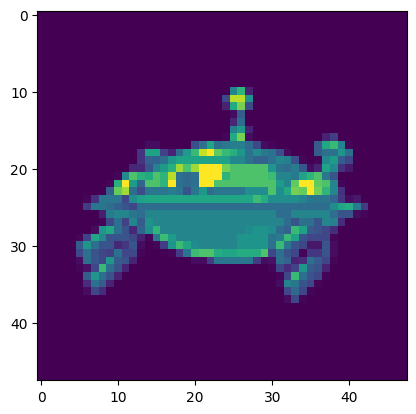

In [657]:
#shuffle
np.random.shuffle(sprites)
plt.imshow(sprites[1])
plt.show()

## Build the model

In [605]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [490]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [687]:
latent_dim = 50

encoder_inputs = keras.Input(shape=(height, width, channels))
x = layers.Conv2D(64, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2 * latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_61 (Conv2D)             (None, 48, 48, 64)   640         ['input_45[0][0]']               
                                                                                                  
 conv2d_62 (Conv2D)             (None, 48, 48, 64)   36928       ['conv2d_61[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 24, 24, 64)  0           ['conv2d_62[0][0]']              
 )                                                                                          

In [686]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense((height // 4) * (width//4) * 64, activation="relu")(latent_inputs)
x = layers.Reshape((height//4, width//4, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(channels, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 500)]             0         
                                                                 
 dense_45 (Dense)            (None, 9216)              4617216   
                                                                 
 dense_46 (Dense)            (None, 9216)              84943872  
                                                                 
 reshape_18 (Reshape)        (None, 12, 12, 64)        0         
                                                                 
 conv2d_transpose_51 (Conv2D  (None, 24, 24, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_52 (Conv2D  (None, 48, 48, 32)       18464     
 Transpose)                                                

In [688]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [689]:
x_train, x_test = np.split(normalizedSprites, [int(normalizedSprites.shape[0] * 0.8)])

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(normalizedSprites, epochs=50, batch_size=128)

Epoch 1/50
10/10 [==============================] - 13s 1s/step - loss: 1210.6600 - reconstruction_loss: 963.9577 - kl_loss: 0.3286
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 635.9349 - reconstruction_loss: 571.9210 - kl_loss: 17.1151
Epoch 3/50
10/10 [==============================] - 12s 1s/step - loss: 538.9752 - reconstruction_loss: 530.0598 - kl_loss: 7.8864
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 530.2675 - reconstruction_loss: 523.3714 - kl_loss: 8.5016
Epoch 5/50
10/10 [==============================] - 13s 1s/step - loss: 524.0008 - reconstruction_loss: 531.3935 - kl_loss: 7.4642
Epoch 6/50
10/10 [==============================] - 13s 1s/step - loss: 501.1024 - reconstruction_loss: 496.2121 - kl_loss: 7.5214
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 518.6200 - reconstruction_loss: 516.7995 - kl_loss: 9.0155
Epoch 8/50
10/10 [==============================] - 13s 1s/step - loss: 513.9737 

KeyboardInterrupt: 

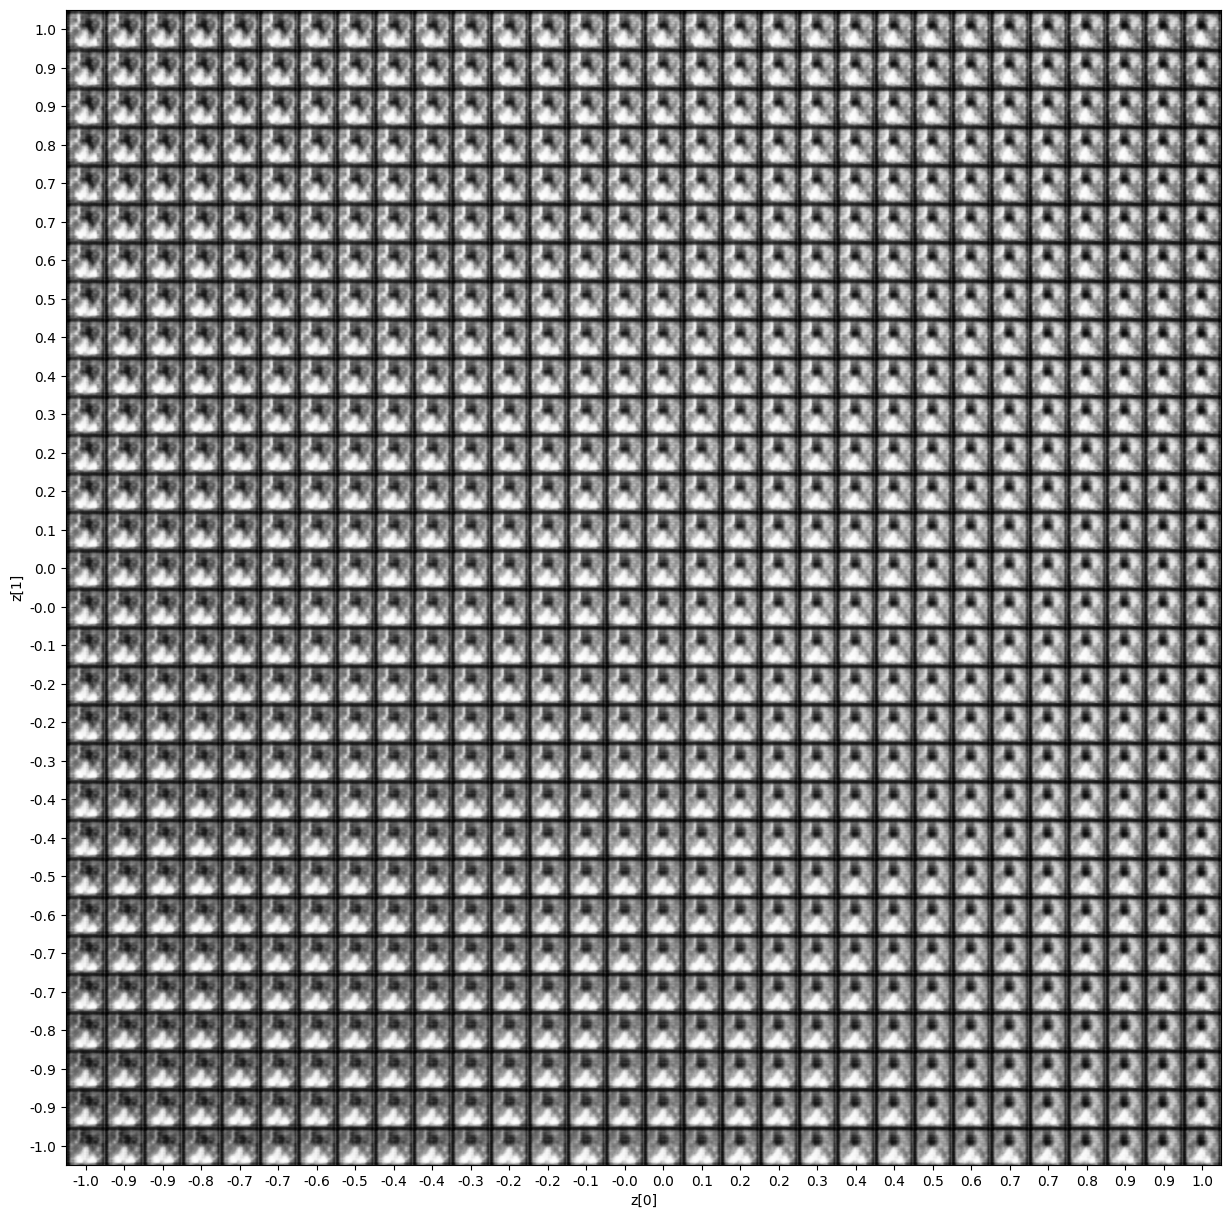

In [176]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = width
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, channels))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi] + [0] * (latent_dim - 2)])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, channels)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [690]:
predictions = encoder.predict(normalizedSprites)

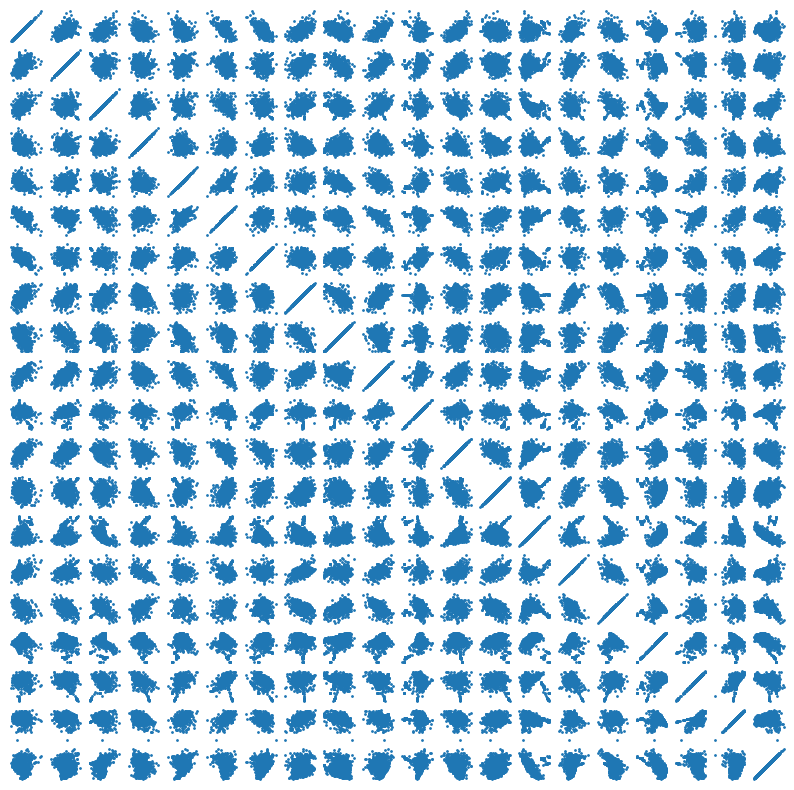

In [183]:
#plot all the couple of latent variables in a matrix of scatter plots
plt.figure(figsize=(10, 10))


for i in range(latent_dim):
    for j in range(latent_dim):
        plt.subplot(latent_dim, latent_dim, j*latent_dim + i + 1)
        #remove axis
        plt.axis('off')
        #remove axis ticks
        plt.xticks([])
        plt.yticks([])
        plt.scatter(predictions[0][:,i], predictions[0][:,j], s=1)
plt.show()


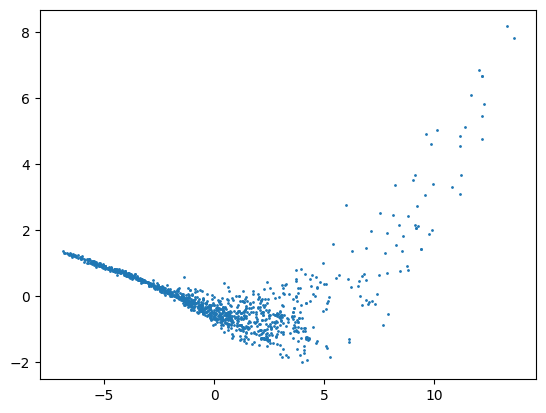

In [691]:
#pca on the latent space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(predictions[0])
pca_predictions = pca.transform(predictions[0])

#plot the pca latent space
plt.scatter(pca_predictions[:,0], pca_predictions[:,1], s=1)
plt.show()

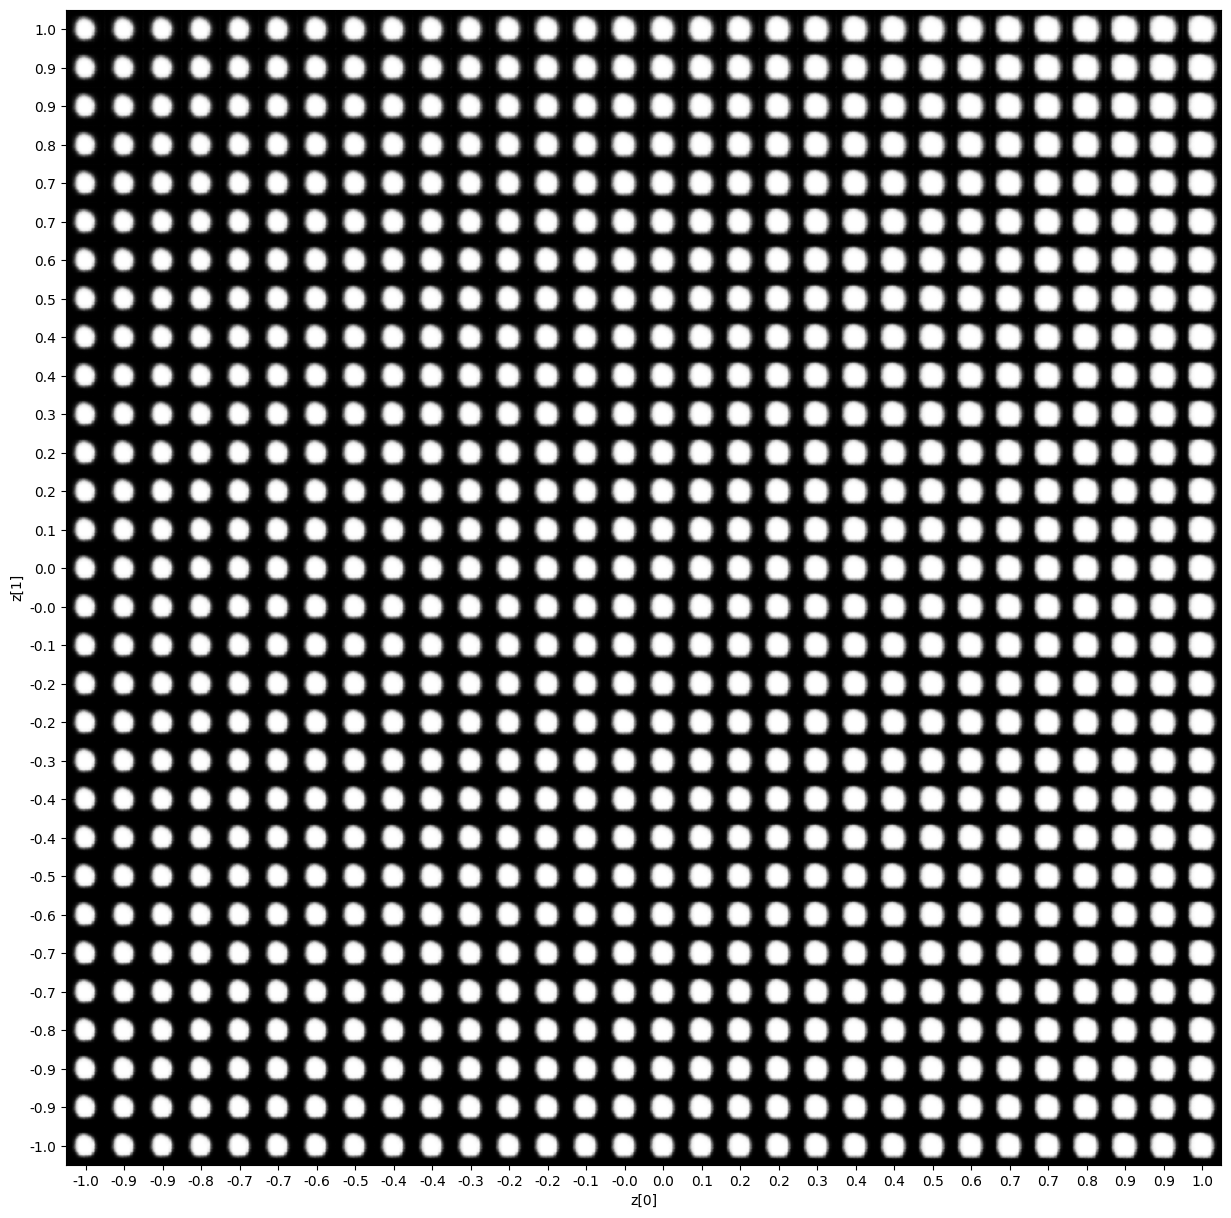

In [666]:
#sample the pca latent space and plot the generated sprites from the decoder network in a grid

import matplotlib.pyplot as plt


def plot_latent_space_pca(vae, pca, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = width
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, channels))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            z_sample = pca.inverse_transform(z_sample)
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, channels)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space_pca(vae, pca)

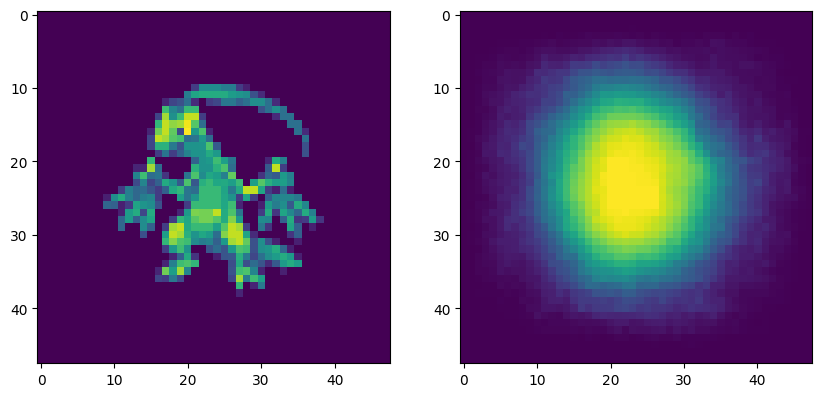

In [713]:
sample = np.random.randint(0, normalizedSprites.shape[0])
#side by side comparison of the original image and the reconstructed one
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(normalizedSprites[sample])
plt.subplot(1, 2, 2)
plt.imshow(decoder.predict(np.array([predictions[0][sample]]))[0])
plt.show()